In [1]:
expname   = "exp006_20250526_sna_kadirerdem"
modelname = "dev015_exp007_cnn.pth"

In [2]:
from auxiliary import loadData_staticTargetAddrMatch, prepare_data_loaders, create_sequential_inference_loader
from auxiliary import normalize_rss_data, denormalize_predictions, denormalize_rss
from algorithms import RssPosAlgo_NeuralNet_CNNv1
from algorithms import RssPosAlgo_NeuralNet_supervisedTrainingLoop
from algorithms import RssPosAlgo_NearestNeighbour
from algorithms import RssPosAlgo_NearestNeighbour_Interpolation
from algorithms import RssPosAlgo_NearestNeighbour_GetKmeansDb
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
target_adresses = ["d8:47:32:eb:6c:38",
                    "50:c7:bf:19:e6:4d",
                    "18:28:61:3d:94:7a"]

In [4]:
datajsonpath = "../experiments/"+expname+"/data-tshark/data.json"
inp_rss_vals, gt_locations = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                            target_addresses=target_adresses, snap250ms=False)

batch_size       = 64
train_test_split = 0.9
kernel_sizes     = [13, 9, 7, 5]  # Changed from single kernelsize to list
channels         = [16, 8, 4, 2]
total_reduction  = sum(k - 1 for k in kernel_sizes)
min_input_length = total_reduction + 1
window_size      = min_input_length # 50
print(window_size)

# Normalize your data before training
inp_rss_vals_norm, gt_locations_norm, norm_params = normalize_rss_data(
    inp_rss_vals, gt_locations, 
    fit_on_train=True, 
    train_split=train_test_split
)

# Use normalized data for training
train_loader, test_loader, xtr, ytr, xts, yts = prepare_data_loaders(
    inp_rss_vals_norm, gt_locations_norm, 
    batch_size=batch_size, window_size=window_size,
    train_test_split=train_test_split,
    cnn_data=True, cnn_kernel_sizes=kernel_sizes
)

#test_loader = train_loader
#xts = xtr
#yts = ytr

31
RSS normalization - Mean: [-65.92789035 -61.44934446 -64.2920143 ], Std: [4.48200446 5.04752115 5.06436009]
Location normalization - Mean: [1.73622972 2.01734915], Std: [0.94198072 1.44759645]


# plot labels

In [5]:
def plot_rss_vs_position(inp_rss_vals, gt_locations, window_size=50):
    """
    Plot filtered RSS values and positions over time to visualize correlations
    """
    # Apply moving average filter to RSS values using 'valid' mode to avoid edge effects
    filtered_rss_0 = np.convolve(inp_rss_vals[:,0], np.ones(window_size)/window_size, mode='valid')
    filtered_rss_1 = np.convolve(inp_rss_vals[:,1], np.ones(window_size)/window_size, mode='valid')
    filtered_rss_2 = np.convolve(inp_rss_vals[:,2], np.ones(window_size)/window_size, mode='valid')
    
    filtered_rss = np.column_stack([filtered_rss_0, filtered_rss_1, filtered_rss_2])
    
    # Trim ground truth locations to match filtered RSS length
    # 'valid' mode reduces length by (window_size - 1)
    trim_start = window_size // 2
    trim_end = len(gt_locations) - (window_size - 1 - trim_start)
    gt_locations_trimmed = gt_locations[trim_start:trim_end]
    
    # Create time indices for the trimmed data
    time_indices = range(len(filtered_rss))
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'RSS and Position Over Time (Moving Average Window: {window_size})', fontsize=16)
    
    # Plot 1: RSS values and X position over time
    ax1 = axes[0]
    ax1.plot(time_indices, filtered_rss[:, 0], 'r-', alpha=0.7, label='RSS AP1')
    ax1.plot(time_indices, filtered_rss[:, 1], 'g-', alpha=0.7, label='RSS AP2')
    ax1.plot(time_indices, filtered_rss[:, 2], 'b-', alpha=0.7, label='RSS AP3')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('RSS (dBm)', color='black')
    ax1.set_title('RSS Values and X Position Over Time')
    ax1.grid(True, alpha=0.3)
    
    # Create second y-axis for X position
    ax1_twin = ax1.twinx()
    ax1_twin.plot(time_indices, gt_locations_trimmed[:, 0], 'k-', linewidth=1, label='X Position')
    ax1_twin.set_ylabel('X Position (m)', color='black')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Plot 2: RSS values and Y position over time
    ax2 = axes[1]
    ax2.plot(time_indices, filtered_rss[:, 0], 'r-', alpha=0.7, label='RSS AP1')
    ax2.plot(time_indices, filtered_rss[:, 1], 'g-', alpha=0.7, label='RSS AP2')
    ax2.plot(time_indices, filtered_rss[:, 2], 'b-', alpha=0.7, label='RSS AP3')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('RSS (dBm)', color='black')
    ax2.set_title('RSS Values and Y Position Over Time')
    ax2.grid(True, alpha=0.3)
    
    # Create second y-axis for Y position
    ax2_twin = ax2.twinx()
    ax2_twin.plot(time_indices, gt_locations_trimmed[:, 1], 'k-', linewidth=1, label='Y Position')
    ax2_twin.set_ylabel('Y Position (m)', color='black')
    
    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.savefig('rss_vs_position_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return filtered_rss, gt_locations_trimmed

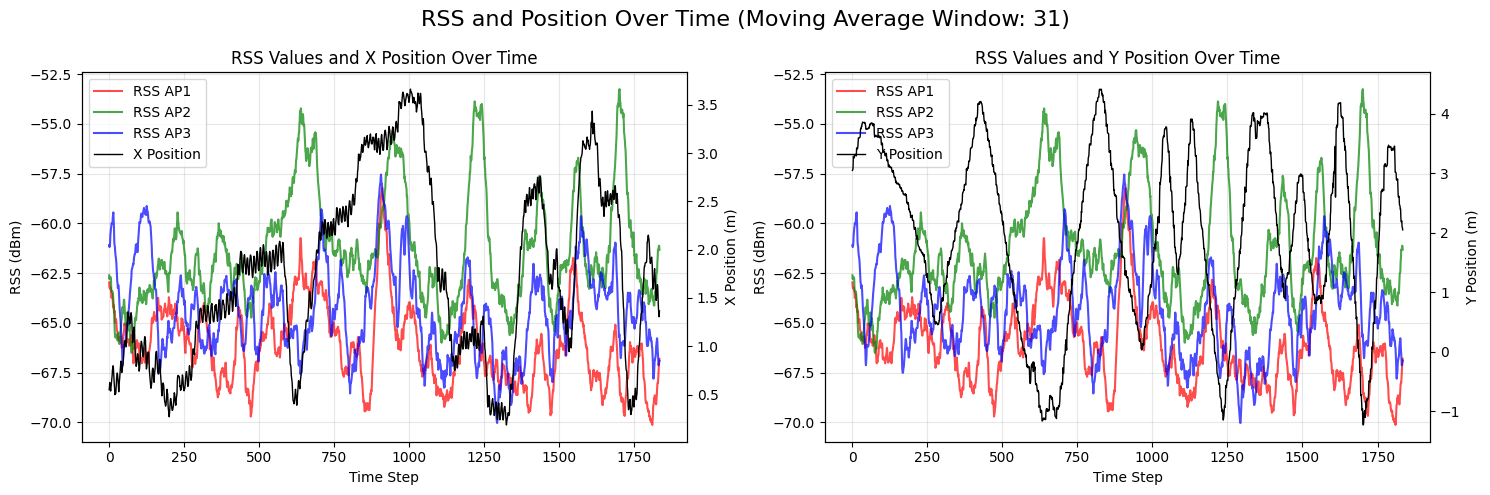

In [6]:
# Call the function
filtered_rss, _ = plot_rss_vs_position(inp_rss_vals, gt_locations, window_size=window_size)

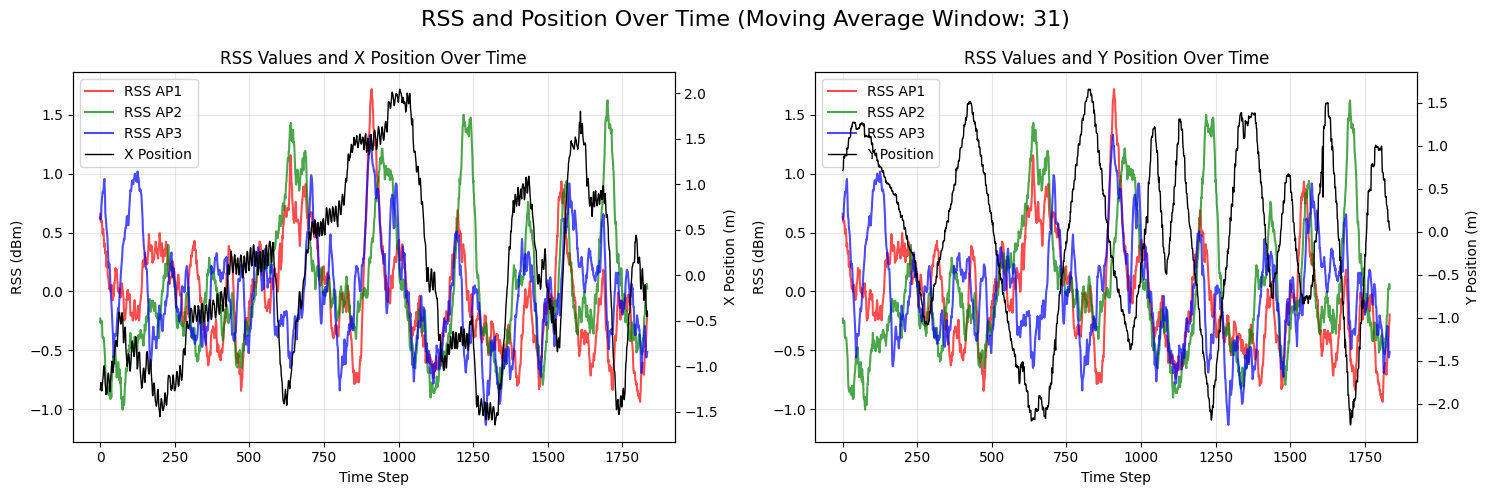

In [7]:
# Call the function
filtered_rss, _ = plot_rss_vs_position(inp_rss_vals_norm, gt_locations_norm, window_size=window_size)

# Modeling

In [8]:
print("Subset sizes | train:", xtr.shape, ", test:",xts.shape)
cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes)
cnn.train()
cnn.cuda()
cnn.device="cuda"

cnn_criterion = nn.MSELoss(reduction='mean')
cnn_optimizer = optim.Adam(cnn.parameters(), lr=5e-4)

Subset sizes | train: torch.Size([1678, 3]) , test: torch.Size([187, 3])


In [9]:
sum(p.numel() for p in cnn.parameters() if p.requires_grad)

2070

In [10]:
epochs           = 201
cnn = RssPosAlgo_NeuralNet_supervisedTrainingLoop(train_loader = train_loader, 
                                                  test_loader  = test_loader,
                                                  model        = cnn, 
                                                  criterion    = cnn_criterion, 
                                                  optimizer    = cnn_optimizer, 
                                                  epochs       = epochs,
                                                  testfreq     = 20) # testfreq is in epochs

Epoch [1/201] test loss: 0.923, training loss: -1.000
Epoch [21/201] test loss: 0.463, training loss: 0.418
Epoch [41/201] test loss: 0.165, training loss: 0.161
Epoch [61/201] test loss: 0.099, training loss: 0.095
Epoch [81/201] test loss: 0.074, training loss: 0.074
Epoch [101/201] test loss: 0.061, training loss: 0.061
Epoch [121/201] test loss: 0.050, training loss: 0.052
Epoch [141/201] test loss: 0.045, training loss: 0.044
Epoch [161/201] test loss: 0.037, training loss: 0.036
Epoch [181/201] test loss: 0.033, training loss: 0.032
Epoch [201/201] test loss: 0.030, training loss: 0.028


In [11]:
torch.save(cnn.state_dict(), 'savedmodels/'+modelname)

In [12]:
cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes)
cnn.load_state_dict(torch.load('savedmodels/'+modelname));
cnn.eval();

In [13]:
error = 0  # Initialize the error accumulator
for test_inputs, test_labels in test_loader:
    loc_pred_cnn_normalized = cnn(test_inputs)
    loc_pred_cnn = denormalize_predictions(loc_pred_cnn_normalized, norm_params)
    loc_pred_cnn_np = loc_pred_cnn
    yts_batch_np = denormalize_predictions(test_labels, norm_params)
    diff = yts_batch_np - loc_pred_cnn_np
    error1 = 0
    for i in range(diff.shape[-1]):
        error1 += np.linalg.norm(diff[:,:,i])
    error += error1/diff.shape[-1]

print("Mean error:", error/len(test_loader))

Mean error: 0.24528557688252714


In [14]:
num_clusterss = [3,4,5,7,9,11,13]
for num_clusters in num_clusterss:
    print("-"*20)
    print("# of clusters:", num_clusters)
    db_kmeans = RssPosAlgo_NearestNeighbour_GetKmeansDb(xtr, ytr, num_clusters=num_clusters)
    meanerror_nene_interp = 0;
    meanerror_nene        = 0;
    for test_idx, x_test_sample in enumerate(xts): 
        loc_pred_nene_normalized          = RssPosAlgo_NearestNeighbour(x_test_sample, db_kmeans)
        loc_pred_nene = denormalize_predictions(loc_pred_nene_normalized, norm_params)
        loc_pred_nene_interp_normalized   = RssPosAlgo_NearestNeighbour_Interpolation(x_test_sample, db_kmeans)
        loc_pred_nene_interp = denormalize_predictions(loc_pred_nene_interp_normalized, norm_params)        
        meanerror_nene        += (denormalize_predictions(yts[test_idx], norm_params) - loc_pred_nene)**2
        meanerror_nene_interp += np.linalg.norm((denormalize_predictions(yts[test_idx], norm_params) - loc_pred_nene_interp))
    print("NeNe       :", np.linalg.norm(meanerror_nene/(test_idx+1)))
    print("NeNe+Interp:", np.linalg.norm(meanerror_nene_interp/(test_idx+1)))

--------------------
# of clusters: 3
NeNe       : 2.380860273821358
NeNe+Interp: 1.4781343673124097
--------------------
# of clusters: 4
NeNe       : 3.0054031946629567
NeNe+Interp: 1.4538498790702599
--------------------
# of clusters: 5
NeNe       : 2.7031033329443757
NeNe+Interp: 1.3741023337284015
--------------------
# of clusters: 7
NeNe       : 2.9333366292321226
NeNe+Interp: 1.3960058540007074
--------------------
# of clusters: 9
NeNe       : 3.122214407302761
NeNe+Interp: 1.3889367979037124
--------------------
# of clusters: 11
NeNe       : 3.1679169137135337
NeNe+Interp: 1.4180512801236091
--------------------
# of clusters: 13
NeNe       : 3.1504041536935716
NeNe+Interp: 1.4812174208291742


# plotting

In [15]:
def run_sequential_inference(sequential_loader, cnn_model, db_kmeans, xts, yts, norm_params, db_is_normalized=True):
    """
    Run all three methods through sequential data and collect results
    
    Args:
        db_is_normalized: True if db_kmeans was built with normalized location data,
                         False if built with denormalized location data
    """
    from algorithms import RssPosAlgo_NearestNeighbour, RssPosAlgo_NearestNeighbour_Interpolation
    
    cnn_predictions = []
    cnn_ground_truths = []
    knn_predictions = []
    knn_interp_predictions = []
    knn_ground_truths = []
    
    print(f"Running sequential inference on {len(sequential_loader)} windows...")
    
    # Process CNN data sequentially
    with torch.no_grad():
        for window_idx, (x_window, y_window) in enumerate(sequential_loader):
            # CNN prediction (CNN works on normalized data, outputs normalized predictions)
            cnn_pred_normalized = cnn_model(x_window)
            cnn_pred = denormalize_predictions(cnn_pred_normalized, norm_params)
            cnn_predictions.append(cnn_pred)
            
            # Handle ground truth - y_window should be normalized if coming from normalized dataset
            y_denorm = denormalize_predictions(y_window, norm_params)
            cnn_ground_truths.append(y_denorm)
    
    # Process K-NN data (using individual samples from xts, yts)
    print(f"Running K-NN inference on {len(xts)} samples...")
    for i, x_sample in enumerate(xts):
        # K-NN expects normalized RSS input if database was built with normalized RSS
        # But RSS normalization doesn't affect the coordinate outputs
        
        # K-NN predictions
        knn_pred = RssPosAlgo_NearestNeighbour(x_sample, db_kmeans)
        knn_interp_pred = RssPosAlgo_NearestNeighbour_Interpolation(x_sample, db_kmeans)
        
        # Handle K-NN prediction denormalization based on how database was built
        if db_is_normalized:
            # Database was built with normalized locations, so predictions are normalized
            knn_pred = denormalize_predictions(knn_pred, norm_params)
            knn_interp_pred = denormalize_predictions(knn_interp_pred, norm_params)
        # If db_is_normalized=False, predictions are already in original scale
        
        knn_predictions.append(knn_pred)
        knn_interp_predictions.append(knn_interp_pred)
        
        # Ground truth - yts should be normalized if from normalized dataset
        gt_denorm = denormalize_predictions(yts[i].numpy(), norm_params)
        knn_ground_truths.append(gt_denorm)
    
    # Convert to numpy arrays
    results = {
        'cnn_predictions': np.array(cnn_predictions),
        'cnn_ground_truths': np.array(cnn_ground_truths),
        'knn_predictions': np.array(knn_predictions),
        'knn_interp_predictions': np.array(knn_interp_predictions),
        'knn_ground_truths': np.array(knn_ground_truths)
    }
    
    # Calculate errors
    results['cnn_errors'] = np.linalg.norm(results['cnn_ground_truths'] - results['cnn_predictions'], axis=1)
    results['knn_errors'] = np.linalg.norm(results['knn_ground_truths'] - results['knn_predictions'], axis=1)
    results['knn_interp_errors'] = np.linalg.norm(results['knn_ground_truths'] - results['knn_interp_predictions'], axis=1)
    
    # Print performance summary
    print("\n" + "="*50)
    print("SEQUENTIAL INFERENCE PERFORMANCE SUMMARY")
    print("="*50)
    print(f"CNN Error: {np.mean(results['cnn_errors']):.3f} ± {np.std(results['cnn_errors']):.3f} m")
    print(f"K-NN Error: {np.mean(results['knn_errors']):.3f} ± {np.std(results['knn_errors']):.3f} m")
    print(f"K-NN+Interp Error: {np.mean(results['knn_interp_errors']):.3f} ± {np.std(results['knn_interp_errors']):.3f} m")
    print(f"CNN samples: {len(results['cnn_predictions'])}")
    print(f"K-NN samples: {len(results['knn_predictions'])}")
    print(f"Database built with {'normalized' if db_is_normalized else 'denormalized'} location data")
    
    return results


def plot_sequential_results(results, num_clusters=13, window_size=50):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Sequential Inference Results (K-means clusters: {num_clusters})', fontsize=16)
    
    # Extract final predictions for plotting (handle multi-timestep CNN outputs)
    cnn_preds = results['cnn_predictions']
    cnn_gts = results['cnn_ground_truths']

    cnn_preds_plot = cnn_preds
    cnn_gts_plot = cnn_gts

    knn_interp_preds = np.array(results['knn_interp_predictions'])
    knn_gts = np.array(results['knn_ground_truths'])
    
    # Get actual lengths
    cnn_len = len(results['cnn_errors'])
    knn_len = len(results['knn_interp_errors'])
    
    # Create properly aligned time indices
    knn_time = range(knn_len)
    cnn_start_idx = window_size - 1
    cnn_time = range(cnn_start_idx, cnn_start_idx + cnn_len)
    
    # Extract K-NN data for the overlapping time period with CNN
    # Make sure we don't go beyond the available data
    overlap_start = cnn_start_idx
    overlap_end = min(cnn_start_idx + cnn_len, knn_len)
    actual_overlap_len = overlap_end - overlap_start
    
    # Adjust CNN data to match available overlap
    if actual_overlap_len < cnn_len:
        cnn_preds_plot = cnn_preds_plot[:actual_overlap_len]
        cnn_gts_plot = cnn_gts_plot[:actual_overlap_len]
        cnn_errors_overlap = results['cnn_errors'][:actual_overlap_len]
        cnn_time = range(cnn_start_idx, overlap_end)
    else:
        cnn_errors_overlap = results['cnn_errors']
    
    # Extract overlapping K-NN data
    knn_interp_preds_overlap = knn_interp_preds[overlap_start:overlap_end]
    knn_gts_overlap = knn_gts[overlap_start:overlap_end]
    knn_interp_errors_overlap = results['knn_interp_errors'][overlap_start:overlap_end]
    
    print(f"CNN time range: {min(cnn_time)} to {max(cnn_time)} ({len(cnn_time)} points)")
    print(f"K-NN time range: {min(knn_time)} to {max(knn_time)} ({len(knn_time)} points)")
    print(f"Overlap period: {overlap_start} to {overlap_end-1} ({actual_overlap_len} points)")
    
    # X coordinates over time
    axes[0].plot(knn_time, knn_gts[:, 0], 'k-', label='Ground Truth', linewidth=1, alpha=0.8)
    axes[0].plot(cnn_time, cnn_preds_plot[:, 0, 0, 0], 'b-', label='CNN', alpha=0.9, linewidth=1)
    #axes[0].plot(cnn_time, knn_interp_preds_overlap[:, 0], 'g-', label='K-NN+Interp', alpha=0.7, linewidth=1.5)
    axes[0].axvline(x=cnn_start_idx, color='blue', linestyle=':', alpha=0.5, label='CNN Start')
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('X Coordinate (m)')
    axes[0].set_title('X Coordinates Over Time (Time-Aligned)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Y coordinates over time
    axes[1].plot(knn_time, knn_gts[:, 1], 'k-', label='Ground Truth', linewidth=1, alpha=0.8)
    axes[1].plot(cnn_time, cnn_preds_plot[:, 0, 1, 0], 'b-', label='CNN', alpha=0.9, linewidth=1)
    #axes[1].plot(cnn_time, knn_interp_preds_overlap[:, 1], 'g-', label='K-NN+Interp', alpha=0.7, linewidth=1.5)
    axes[1].axvline(x=cnn_start_idx, color='blue', linestyle=':', alpha=0.5, label='CNN Start')
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('Y Coordinate (m)')
    axes[1].set_title('Y Coordinates Over Time (Time-Aligned)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('sequential_inference_results.png', dpi=300, bbox_inches='tight')
    plt.show()

### test on this set

In [16]:
datajsonpath = "../experiments/"+expname+"/data-tshark/data.json"
inp_rss_vals, gt_locations = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                            target_addresses=target_adresses, snap250ms=False)
# Normalize your data before training
inp_rss_vals_norm, gt_locations_norm, norm_params = normalize_rss_data(
    inp_rss_vals, gt_locations, 
    fit_on_train=True, 
    train_split=train_test_split
)
sequential_loader, xts_full, yts_full = create_sequential_inference_loader(inp_rss_vals=inp_rss_vals_norm, 
                                                                           gt_locations=gt_locations_norm, 
                                                                           window_size=window_size, cnn_data=True, 
                                                                           cnn_kernel_sizes=kernel_sizes)

RSS normalization - Mean: [-65.92789035 -61.44934446 -64.2920143 ], Std: [4.48200446 5.04752115 5.06436009]
Location normalization - Mean: [1.73622972 2.01734915], Std: [0.94198072 1.44759645]


In [17]:
cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes)
cnn.load_state_dict(torch.load('savedmodels/'+modelname));
cnn.eval();
num_clusters = 13  # or whatever number you want to test
db_kmeans = RssPosAlgo_NearestNeighbour_GetKmeansDb(xtr, ytr, num_clusters=num_clusters)

In [18]:
# Run sequential inference
sequential_results = run_sequential_inference(sequential_loader, cnn, db_kmeans, xts_full, yts_full, norm_params)

Running sequential inference on 1835 windows...
Running K-NN inference on 1865 samples...

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.138 ± 0.175 m
K-NN Error: 1.775 ± 1.060 m
K-NN+Interp Error: 1.556 ± 0.868 m
CNN samples: 1835
K-NN samples: 1865
Database built with normalized location data


CNN time range: 30 to 1864 (1835 points)
K-NN time range: 0 to 1864 (1865 points)
Overlap period: 30 to 1864 (1835 points)


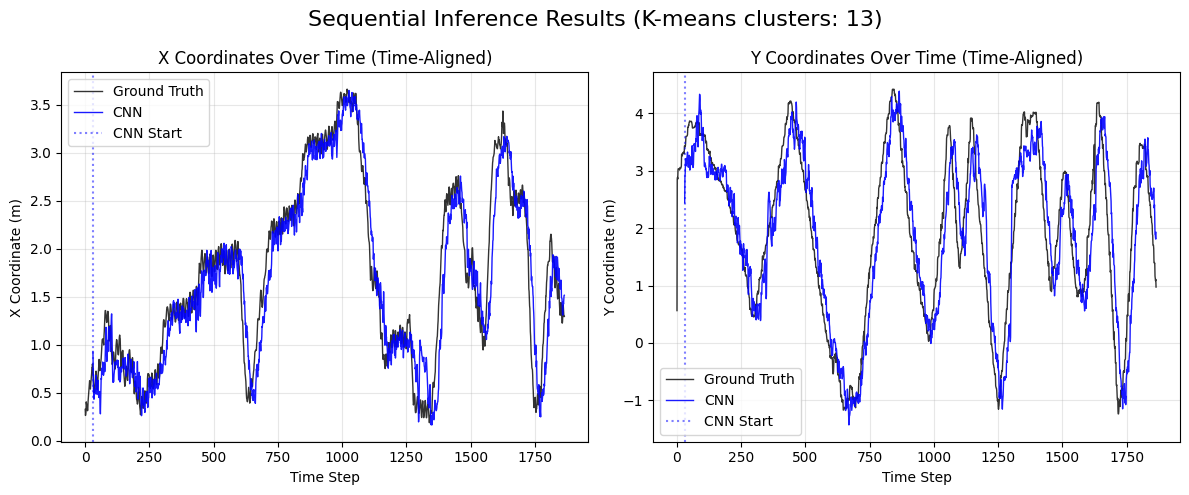

In [19]:
plot_sequential_results(sequential_results, num_clusters=num_clusters, window_size=window_size)

### test on another set

In [20]:
datajsonpath = "../experiments/"+"exp005_20250526_sna_kadirerdem"+"/data-tshark/data.json"
inp_rss_vals, gt_locations = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                            target_addresses=target_adresses, snap250ms=False)
# Normalize your data before training
inp_rss_vals_norm, gt_locations_norm, norm_params = normalize_rss_data(
    inp_rss_vals, gt_locations, 
    fit_on_train=True, 
    train_split=train_test_split
)
sequential_loader, xts_full, yts_full = create_sequential_inference_loader(inp_rss_vals=inp_rss_vals_norm, 
                                                                           gt_locations=gt_locations_norm, 
                                                                           window_size=window_size, cnn_data=True, 
                                                                           cnn_kernel_sizes=kernel_sizes)

RSS normalization - Mean: [-66.60327456 -62.2581864  -66.37279597], Std: [4.42685181 4.50105946 5.03284582]
Location normalization - Mean: [1.50365055 2.13363445], Std: [1.03082177 1.04835198]


In [21]:
cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes)
cnn.load_state_dict(torch.load('savedmodels/'+modelname));
cnn.eval();
num_clusters = 13  # or whatever number you want to test
db_kmeans = RssPosAlgo_NearestNeighbour_GetKmeansDb(xtr, ytr, num_clusters=num_clusters)

In [22]:
# Run sequential inference
sequential_results = run_sequential_inference(sequential_loader, cnn, db_kmeans, xts_full, yts_full, norm_params)

Running sequential inference on 853 windows...
Running K-NN inference on 883 samples...

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.933 ± 0.749 m
K-NN Error: 1.729 ± 0.937 m
K-NN+Interp Error: 1.519 ± 0.739 m
CNN samples: 853
K-NN samples: 883
Database built with normalized location data


CNN time range: 30 to 882 (853 points)
K-NN time range: 0 to 882 (883 points)
Overlap period: 30 to 882 (853 points)


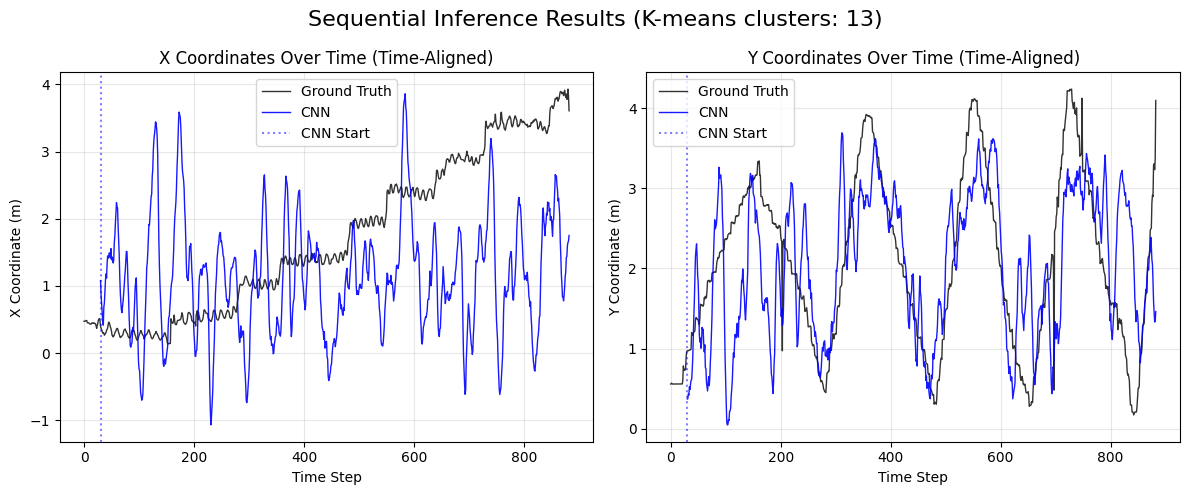

In [23]:
plot_sequential_results(sequential_results, num_clusters=num_clusters, window_size=window_size)

### test on another set

In [24]:
datajsonpath = "../experiments/"+"exp007_20250526_sna_kadirerdem"+"/data-tshark/data.json"
inp_rss_vals, gt_locations = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                            target_addresses=target_adresses, snap250ms=False)
# Normalize your data before training
inp_rss_vals_norm, gt_locations_norm, norm_params = normalize_rss_data(
    inp_rss_vals, gt_locations, 
    fit_on_train=True, 
    train_split=train_test_split
)
sequential_loader, xts_full, yts_full = create_sequential_inference_loader(inp_rss_vals=inp_rss_vals_norm, 
                                                                           gt_locations=gt_locations_norm, 
                                                                           window_size=window_size, cnn_data=True, 
                                                                           cnn_kernel_sizes=kernel_sizes)

RSS normalization - Mean: [-67.09640288 -61.45419664 -65.48105516], Std: [4.63660873 5.29851686 5.70070893]
Location normalization - Mean: [1.90250298 1.85889336], Std: [0.97173144 1.39449037]


In [25]:
cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes)
cnn.load_state_dict(torch.load('savedmodels/'+modelname));
cnn.eval();
num_clusters = 13  # or whatever number you want to test
db_kmeans = RssPosAlgo_NearestNeighbour_GetKmeansDb(xtr, ytr, num_clusters=num_clusters)

In [26]:
# Run sequential inference
sequential_results = run_sequential_inference(sequential_loader, cnn, db_kmeans, xts_full, yts_full, norm_params)

Running sequential inference on 2287 windows...
Running K-NN inference on 2317 samples...

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.954 ± 0.726 m
K-NN Error: 1.874 ± 0.966 m
K-NN+Interp Error: 1.598 ± 0.822 m
CNN samples: 2287
K-NN samples: 2317
Database built with normalized location data


CNN time range: 30 to 2316 (2287 points)
K-NN time range: 0 to 2316 (2317 points)
Overlap period: 30 to 2316 (2287 points)


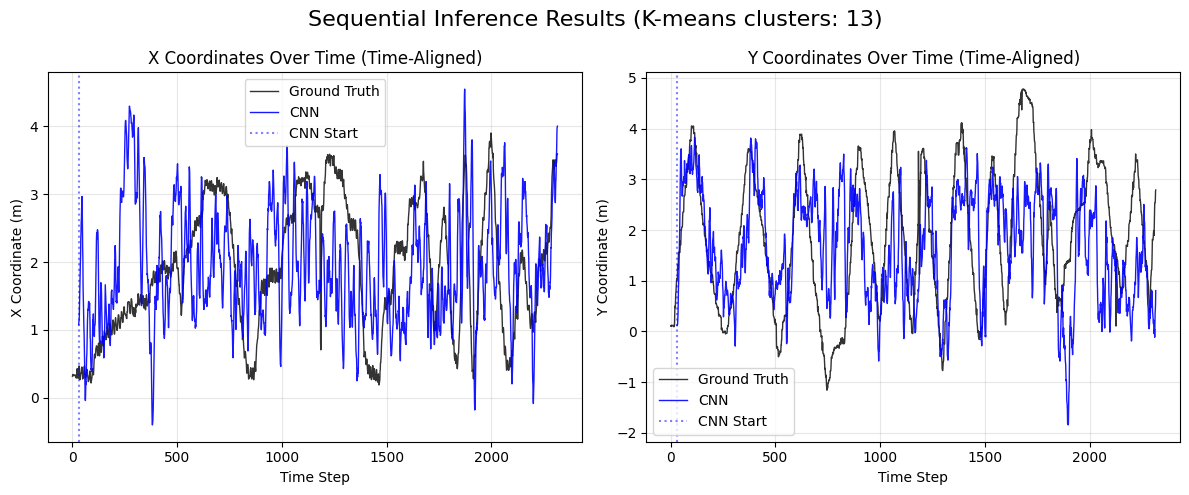

In [27]:
plot_sequential_results(sequential_results, num_clusters=num_clusters, window_size=window_size)

### test on another set

In [28]:
datajsonpath = "../experiments/"+"exp008_20250526_sna_kadirerdem"+"/data-tshark/data.json"
inp_rss_vals, gt_locations = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                            target_addresses=target_adresses, snap250ms=False)
# Normalize your data before training
inp_rss_vals_norm, gt_locations_norm, norm_params = normalize_rss_data(
    inp_rss_vals, gt_locations, 
    fit_on_train=True, 
    train_split=train_test_split
)
sequential_loader, xts_full, yts_full = create_sequential_inference_loader(inp_rss_vals=inp_rss_vals_norm, 
                                                                           gt_locations=gt_locations_norm, 
                                                                           window_size=window_size, cnn_data=True, 
                                                                           cnn_kernel_sizes=kernel_sizes)

RSS normalization - Mean: [-77.96130346 -70.05397149 -78.90427699], Std: [16.98329506 17.38424444 16.63031003]
Location normalization - Mean: [1.73618251 1.94311443], Std: [1.10721434 1.42216561]


In [29]:
cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes)
cnn.load_state_dict(torch.load('savedmodels/'+modelname));
cnn.eval();
num_clusters = 13  # or whatever number you want to test
db_kmeans = RssPosAlgo_NearestNeighbour_GetKmeansDb(xtr, ytr, num_clusters=num_clusters)

In [30]:
# Run sequential inference
sequential_results = run_sequential_inference(sequential_loader, cnn, db_kmeans, xts_full, yts_full, norm_params)

Running sequential inference on 1062 windows...
Running K-NN inference on 1092 samples...

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 1.199 ± 0.931 m
K-NN Error: 2.288 ± 1.129 m
K-NN+Interp Error: 2.037 ± 1.010 m
CNN samples: 1062
K-NN samples: 1092
Database built with normalized location data


CNN time range: 30 to 1091 (1062 points)
K-NN time range: 0 to 1091 (1092 points)
Overlap period: 30 to 1091 (1062 points)


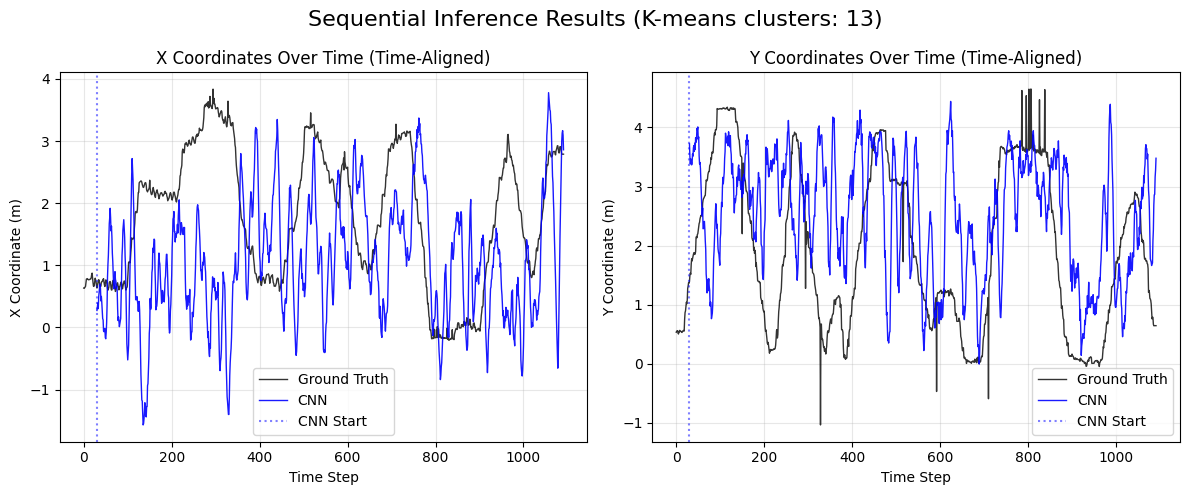

In [31]:
plot_sequential_results(sequential_results, num_clusters=num_clusters, window_size=window_size)